## Using Isolation Forest to Detect Criminally-Linked Properties

The goal of this notebook is to apply the Isolation Forest anomaly detection algorithm to the property data. The algorithm is particularly good at detecting anomalous data points in cases of extreme class imbalance. After normalizing the data and splitting into a training set and testing set, I trained the first model. 

Because the rate of criminally-linked properties in the data is only 0.00885%, I chose to start with a very low contamination parameter (the proportion of outliers in the data). After visualizing this first model's poor performance, I was hopeful that gridsearching would provide a model with better performance.

Next, I manually selected a few features that, based on my experience investigating money-laundering and asset tracing, I thought would be most important and trained a model on just those.

In the final section, I reduce the dataset to properties I can say with confidence are either "criminal" or "normal." I then train an Isolation Forest model on this reduced dataset.

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, make_scorer, precision_score
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('dark')

### Full Dataset

#### Load Data and Remove Columns

In [22]:
# Read in the data
df = pd.read_hdf('../data/processed/bexar_processed.h5')

# Fill na values for price_psf with 0 (means it's an empty lot)
df['price_psf'] = df['price_psf'].fillna(0)

# Filter out wonky situations (erroneous property encoding, sq footage of 1, etc.)
trim_prop_df = df[(df.price_psf<df.price_psf.quantile(.999))]

In [23]:
# Grab all columns that are under the 70,000 nan limit
nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop([
    'prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
    'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
    'bexar_2017_market_value','bexar_2018_market_value','owner_zip_code',
    'property_zip','neighborhood_code'
])

sub_df = trim_prop_df[variables_list]
df_if = sub_df.dropna()
print("Number of properties after trimming:", len(df_if))

Number of properties after trimming: 583619


In [24]:
# Get criminal property rate
crim_prop_rate = 1 - (len(df_if[df_if['crim_prop']==0]) / len(df_if))
print("Rate is: {:.5%}".format(crim_prop_rate))

Rate is: 0.00805%


In [25]:
# Re-label the normal properties with 1 and the criminal ones with -1
df_if['binary_y'] = [1 if x==0 else -1 for x in df_if.crim_prop]
print(df_if.binary_y.value_counts())

 1    583572
-1        47
Name: binary_y, dtype: int64


/Users/matthewpokorny/anaconda3/envs/prop_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# Normalize the data
X = df_if.iloc[:,:-2]
X_norm = preprocessing.normalize(X)

y = df_if.binary_y

# Split the data into train and test
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(
    X_norm, y, test_size=0.33, random_state=42
)

#### First Model - All Features Included

For the first model, I included all the features and set the contamination to 0.01, because the class imbalance is so high.

In [27]:
# Set parameters
clf = IsolationForest(
    max_samples=0.2,
    n_estimators=100,
    contamination=0.01,
    random_state=42
)

# Fit the model
clf.fit(X_train_norm,y_train_norm)
# Predict
y_pred_train = clf.predict(X_train_norm)

In [28]:
# Define function to plot resulting confusion matrix
def plot_confusion_matrix(conf_matrix, title, classes=['criminally-linked', 'normal'],
                          cmap=plt.cm.Oranges):

    # Plot confusion matrix with heatmap and classification statistics
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8,8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=18)
    plt.colorbar(pad=.12)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=11)
    plt.yticks(tick_marks, classes, rotation=45, fontsize=11)

    fmt = '.4%'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="top",
                 fontsize=16,
                 color="white" if conf_matrix[i, j] > thresh else "black")
    plt.ylabel('True label',fontsize=14, rotation=0)
    plt.xlabel('Predicted label',fontsize=14)

#### Model Performance on Training Data

In [29]:
# Function for returning the model metrics
def metrics_iforest(y_true,y_pred):
    
    print('Model recall is',recall_score(
        y_true,
        y_pred,
        zero_division=0,
        pos_label=-1
    ))
    print('Model precision is',precision_score(
        y_true,
        y_pred,
        zero_division=0,
        pos_label=-1
    ))

    print("Model AUC is", roc_auc_score(y_true, y_pred))

In [30]:
metrics_iforest(y_train_norm,y_pred_train)

Model recall is 0.06451612903225806
Model precision is 0.0005113781641523907
Model AUC is 0.5272592537957325


[[     2     29]
 [  3909 387084]]


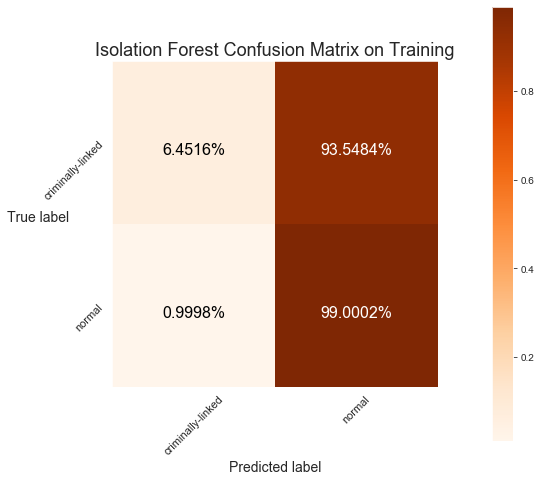

In [31]:
conf_matrix = confusion_matrix(y_train_norm, y_pred_train)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Training')

The model performs quite poorly at two important metrics in a classification problem such as this, recall and precision. Missing all but two of the criminally-linked properties makes for a bad anomaly detector.

#### Gridsearch

Isolation Forest is fairly robust to parameter changes, but changing the contamination can improve performance. I will gridsearch based on a range of contamination from 0.01 to 0.25 in leaps of 0.05. 

In [32]:
%%time
skip = 0
if skip == 0:
    # Set what metrics to evaluate predictions
    scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

    gs = GridSearchCV(
        IsolationForest(max_samples=0.25, random_state=42,n_estimators=100),
        param_grid={'contamination': np.arange(0.01, 0.25, 0.05)},
        scoring=scoring, 
        refit='Recall',
        verbose=0,
        cv=3
    )
    
    # Fit to training data
    gs.fit(X_train_norm,y_train_norm)

CPU times: user 7min 9s, sys: 1min 4s, total: 8min 14s
Wall time: 11min 21s


In [33]:
print(gs.best_params_)

{'contamination': 0.11}


#### Gridsearch Model Performance on Training

In [34]:
y_pred_train_gs = gs.predict(X_train_norm)
metrics_iforest(y_train_norm,y_pred_train_gs)

Model recall is 0.8064516129032258
Model precision is 0.0005812196312742659
Model AUC is 0.8482529552752491


[[    25      6]
 [ 42988 348005]]


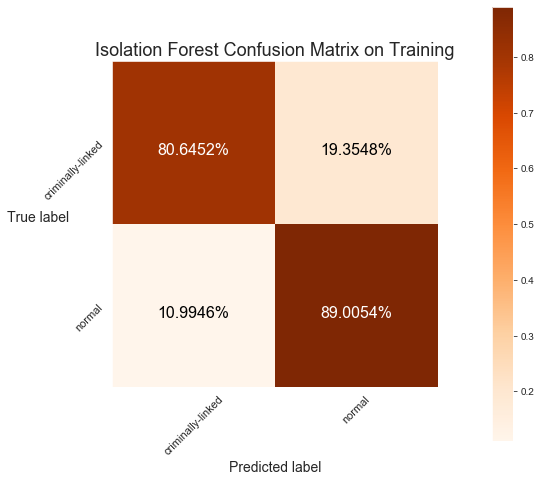

In [35]:
conf_matrix = confusion_matrix(y_train_norm, y_pred_train_gs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Training')

Increasing the contamination parameter drastically improved the model's recall and AUC. Precision is still poor, as there are now 42,988 false positives. Let's see how it holds up on testing data.

#### Gridsearch Model Performance on Testing

In [36]:
y_pred_test_gs = gs.predict(X_test_norm)
metrics_iforest(y_test_norm,y_pred_test_gs)

Model recall is 0.625
Model precision is 0.00047337278106508875
Model AUC is 0.7576783423945498


[[    10      6]
 [ 21115 171464]]


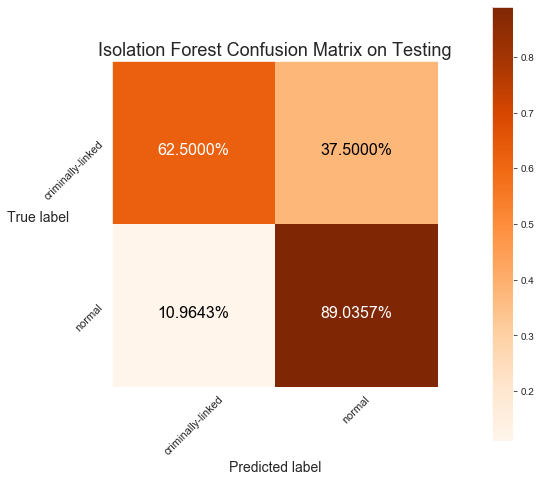

In [38]:
conf_matrix = confusion_matrix(y_test_norm, y_pred_test_gs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Testing')

The model does a bit worse on testing but still far better than the first attempt's performance. While the model now detects 25 out of 31 criminally-linked properties correctly on the training data, it has done so at the expense of drastically increasing false positives. Similarly, the model has falsely labeled 21,115 properties as criminally-linked in the testing data. Given the context of detecting money-laundering and ill-gotten funds, more false positives are acceptable to reduce false negatives, but the model produces far too many.

#### Visualize Distribution of Anomaly Scores

Sklearn's Isolation Forest provides anomaly scores for each property where the lower the score, the more anomalous the datapoint is.

In [39]:
# Define function for histograms of anomaly scores
def anomaly_plot(anomaly_scores,anomaly_scores_list,title):
    plt.figure(figsize=[15,9])
    plt.subplot(211)
    plt.hist(anomaly_scores,bins=100,log=False,color='royalblue')
    for xc in anomaly_scores_list:
        plt.axvline(x=xc,color='red',linestyle='--',linewidth=0.5,label='criminally-linked property')
    plt.title(title,fontsize=16)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=14)
    plt.ylabel('Number of properties',fontsize=13)

    plt.subplot(212)
    plt.hist(anomaly_scores,bins=100,log=True,color='royalblue')
    for xc in anomaly_scores_list:
        plt.axvline(x=xc,color='red',linestyle='--',linewidth=0.5,label='criminally-linked property')
    plt.xlabel('Anomaly score',fontsize=13)
    plt.ylabel('Number of properties',fontsize=13)
    plt.title('{} (Log Scale)'.format(title),fontsize=16)

    plt.show()

##### Training Data

In [40]:
# Grab anomaly scores for criminally-linked properties
train_df = pd.DataFrame(X_train_norm)
y_train_series = y_train_norm.reset_index()
train_df['y_value'] = y_train_series.binary_y
train_df['anomaly_scores'] = gs.decision_function(X_train_norm)
anomaly_scores_list = train_df[train_df.y_value==-1]['anomaly_scores']

In [41]:
print("Mean score for outlier properties:",np.mean(anomaly_scores_list))
print("Mean score for normal properties:",np.mean(train_df[train_df.y_value==1]['anomaly_scores']))

Mean score for outlier properties: -0.02278921630985039
Mean score for normal properties: 0.006479175148376817


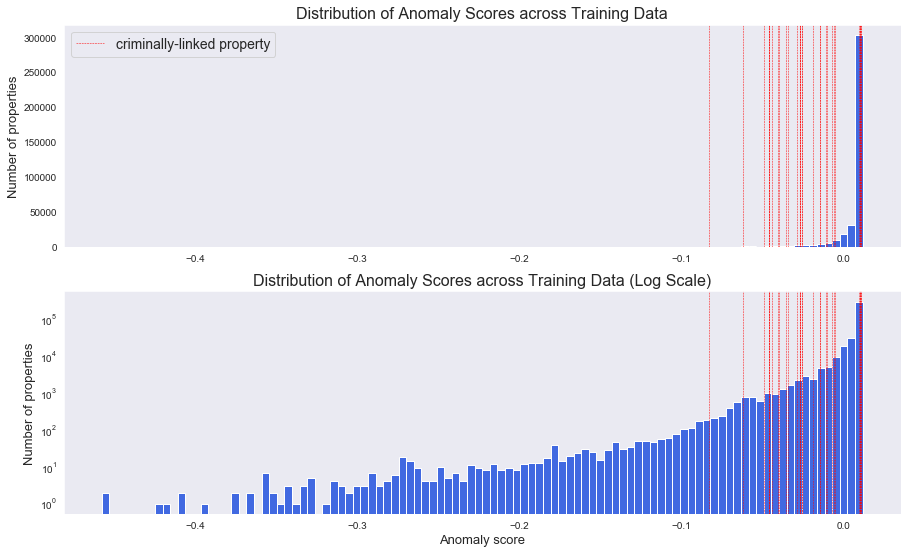

In [42]:
anomaly_plot(train_df['anomaly_scores'],
             anomaly_scores_list,
             title='Distribution of Anomaly Scores across Training Data')

##### Testing Data

In [43]:
test_df = pd.DataFrame(X_test_norm)
y_test_series = y_test_norm.reset_index()
test_df['y_value'] = y_test_series.binary_y
test_df['anomaly_scores'] = gs.decision_function(X_test_norm)
anomaly_scores_list_test = test_df[test_df.y_value==-1]['anomaly_scores']

In [44]:
print("Mean score for outlier properties:",np.mean(anomaly_scores_list_test))
print("Mean score for normal properties:",np.mean(test_df[test_df.y_value==1]['anomaly_scores']))

Mean score for outlier properties: -0.013439906214706192
Mean score for normal properties: 0.00652841229608372


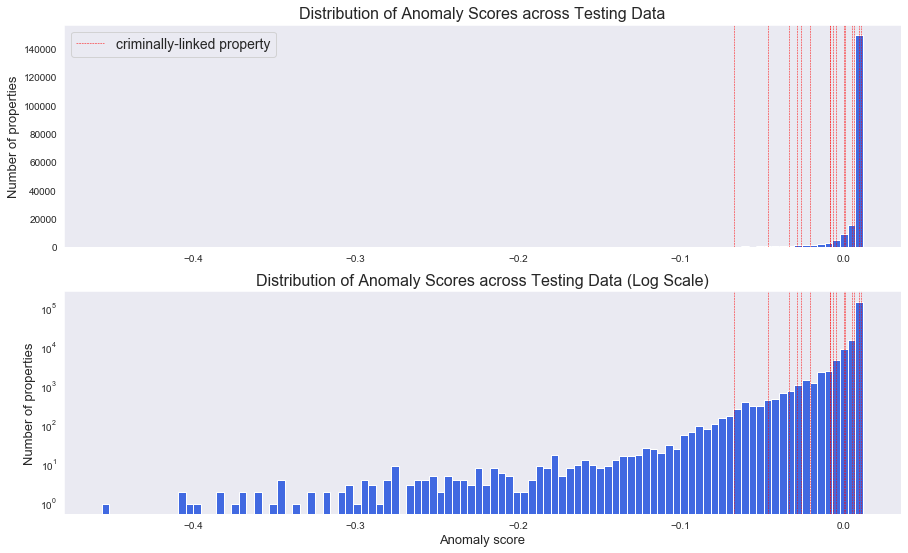

In [45]:
anomaly_plot(test_df['anomaly_scores'], 
             anomaly_scores_list_test, 
             title='Distribution of Anomaly Scores across Testing Data'
)

The top plots give a sense of how skewed the distribution is and how relatively lower the anomaly scores for the criminally-linked properties are when compared to the greater population. The log scale histogram highlights just how many properties do have quite low anomaly scores, which are returned as false positives.

#### Fewer Features

With `feature_importances_` not existing for Isolation Forest, I wanted to see if I could use my background in investigating money laundering to select a few features that would be the best indicators of "abnormal" properties.

In [69]:
# Grab specific columns
X_trim = X[['partial_owner','just_established_owner',
            'foreign_based_owner','out_of_state_owner',
            'owner_legal_person','owner_likely_company',
            'owner_owns_multiple','two_gto_reqs']]

# Normalize
X_trim_norm = preprocessing.normalize(X_trim)

# Split the data into train and test
X_train_trim, X_test_trim, y_train_trim, y_test_trim = train_test_split(
    X_trim_norm, y, test_size=0.33, random_state=42
)

In [70]:
clf_trim = IsolationForest(
    max_samples=0.2,
    n_estimators=100,
    contamination=0.11,
    random_state=42
)

clf_trim.fit(X_train_trim,y_train_trim)
y_pred_train_trim = clf_trim.predict(X_train_trim)

##### Training Data

In [71]:
metrics_iforest(y_train_trim,y_pred_train_trim)

Model recall is 0.782608695652174
Model precision is 0.0627177700348432
Model AUC is 0.8549922527936896


[[  18    5]
 [ 269 3435]]


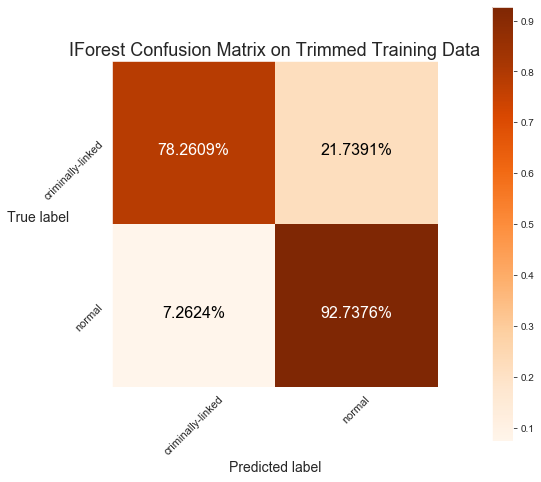

In [72]:
conf_matrix = confusion_matrix(y_train_trim, y_pred_train_trim)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='IForest Confusion Matrix on Trimmed Training Data')

Reducing the features improves the model by two true positives. There are still a tremendous amount of false positives.

##### Testing Data

In [73]:
y_pred_test_trim = clf_trim.predict(X_test_trim)
metrics_iforest(y_test_trim,y_pred_test_trim)

Model recall is 0.875
Model precision is 0.1510791366906475
Model AUC is 0.904939293598234


[[  21    3]
 [ 118 1694]]


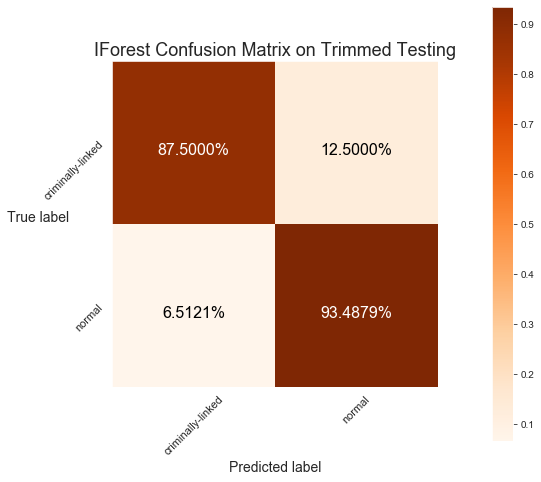

In [74]:
conf_matrix = confusion_matrix(y_test_trim, y_pred_test_trim)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='IForest Confusion Matrix on Trimmed Testing')

Performance improves on the testing data from the gridsearched model trained on all the features, but there's still a high false positive rate.

### Supervised with "True" Labels

In this section, I trim the whole dataset down to just properties I know to either be "criminal" or "normal." The method for labeling a property as normal is the most common property owners in Bexar County are homebuilders and government agencies. Therefore, it is fairly safe to assume the properties owned by these owners are not criminally-linked.

#### Apply Labels and Filter

In [75]:
# Fill na values for price_psf with 0 (means it's an empty lot)
df['price_psf'] = df['price_psf'].fillna(0)

# Filter out wonky situations (erroneous property encoding, sq footage of 1, etc.)
trim_prop_df = df[(df.price_psf<df.price_psf.quantile(.999))]

# Grab all columns that are under the 70,000 nan limit
nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()

top_30_list = trim_prop_df.py_owner_name.value_counts()[:30].index
true_labels_df = trim_prop_df[(trim_prop_df.py_owner_name.str.contains('|'.join(top_30_list))==True) |
            (trim_prop_df.crim_prop==1)
]

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop([
    'prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
    'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
    'bexar_2017_market_value','bexar_2018_market_value','owner_zip_code',
    'property_zip','neighborhood_code'
])

sub_df = true_labels_df[variables_list]
df_if_true_labels = sub_df.dropna()
print("Number of properties after reducing:", len(df_if_true_labels))

Number of properties after reducing: 5563


In [76]:
# Get criminal property rate
crim_prop_rate = 1 - (len(df_if_true_labels[df_if_true_labels['crim_prop']==0]) / len(df_if_true_labels))
print("Rate is: {:.5%}".format(crim_prop_rate))

Rate is: 0.84487%


In [77]:
# Re-label the normal properties with 1 and the criminal ones with -1
df_if_true_labels['binary_y'] = [1 if x==0 else -1 for x in df_if_true_labels.crim_prop]
print(df_if_true_labels.binary_y.value_counts())

 1    5516
-1      47
Name: binary_y, dtype: int64


/Users/matthewpokorny/anaconda3/envs/prop_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
# Normalize the data
X = df_if_true_labels.iloc[:,:-2]
X_norm = preprocessing.normalize(X)

y = df_if_true_labels.binary_y

# Split the data into train and test
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(
    X_norm, y, test_size=0.33, random_state=42
)

#### Gridsearch on reduced dataset

In [61]:
%%time
skip = 0
if skip == 0:
    # Set what metrics to evaluate predictions
    scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

    gs_true_labels = GridSearchCV(
        IsolationForest(max_samples=0.25, random_state=42,n_estimators=100),
        param_grid={'contamination': np.arange(0.01, 0.25, 0.05)},
        scoring=scoring, 
        refit='Recall',
        verbose=0,
        cv=3
    )
    
    # Fit to training data
    gs_true_labels.fit(X_train_norm,y_train_norm)

CPU times: user 5.67 s, sys: 91.8 ms, total: 5.76 s
Wall time: 5.87 s


In [62]:
print(gs_true_labels.best_params_)

{'contamination': 0.21000000000000002}


#### Gridsearch Model Performance on Training

In [64]:
y_pred_train_gs = gs_true_labels.predict(X_train_norm)
metrics_iforest(y_train_norm,y_pred_train_gs)

Model recall is 0.8695652173913043
Model precision is 0.0258732212160414
Model AUC is 0.8331357404451122


[[  20    3]
 [ 753 2951]]


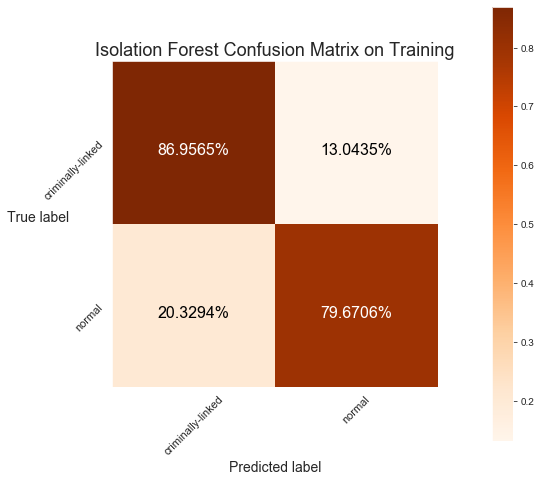

In [65]:
conf_matrix = confusion_matrix(y_train_norm, y_pred_train_gs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Training')

The model detects 20 out of 23 possible "criminally-linked" properties, but still produces a lot of false positives.

#### Gridsearch Model Performance on Testing

Model recall is 0.75
Model precision is 0.04627249357326478
Model AUC is 0.7726269315673289
[[  18    6]
 [ 371 1441]]


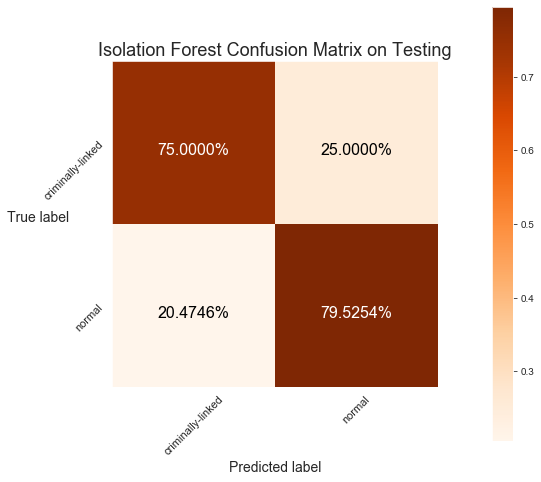

In [79]:
y_pred_test_gs = gs_true_labels.predict(X_test_norm)
metrics_iforest(y_test_norm,y_pred_test_gs)

conf_matrix = confusion_matrix(y_test_norm, y_pred_test_gs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Testing')

Similar issues persist on the testing data.

In [80]:
# Grab anomaly scores for criminally-linked properties
train_df = pd.DataFrame(X_train_norm)
y_train_series = y_train_norm.reset_index()
train_df['y_value'] = y_train_series.binary_y
train_df['anomaly_scores'] = gs_true_labels.decision_function(X_train_norm)
anomaly_scores_list = train_df[train_df.y_value==-1]['anomaly_scores']

print("Mean score for outlier properties:",np.mean(anomaly_scores_list))
print("Mean score for normal properties:",np.mean(train_df[train_df.y_value==1]['anomaly_scores']))

Mean score for outlier properties: -0.06796529810533268
Mean score for normal properties: 0.016148067361463885


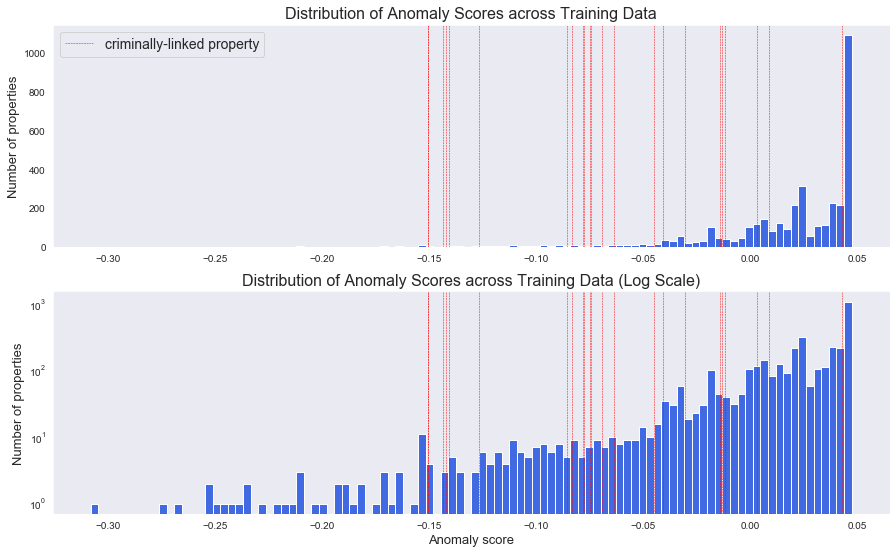

In [81]:
anomaly_plot(train_df['anomaly_scores'],
             anomaly_scores_list,
             title='Distribution of Anomaly Scores across Training Data')

#### Final Notes

- Gridsearching for the contamination parameter drastically affects the model's performance.
- The improved recall scores in the latter two models came at the expense of many more false positives. However, this is an acceptable trade-off given the context.
- It does not appear my expertise in selecting features improves performance.
- There are many properties that the models find more "anomalous" than the true positives. This could indicate the criminals have done a good job of making their properties appear relatively "normal" in the broad spectrum of residential property ownership in Bexar County. While likely not enough to make a large difference, it is quite likely there are more criminally-affiliated properties in the broader population that I have not labeled as such.